In [1]:
# Split years to training and validation sets
train_years = ['2014', '2013', '2012', '2011', '2010', '2009', '2008']
valid_years = ['2017', '2016', '2015']

years = train_years + valid_years

In [2]:
import pandas as pd
import os

days_in_year = 30+31+30+31 # Number of days in months in training examples

#Concatenate years
data = pd.DataFrame()

for year in years:
    filename = os.path.join(*['data','training_data', year])
    df = pd.read_csv(filename, sep=';')
    data = pd.concat([data, df], sort=False) 
    
print(data.shape)
data.head()

# Removing categorical featerus would be done here.
# However it makes learning complicated and it is giving worse results

# Remove categorical feature with one-hot encoding
# categorical_features = ["winddir16Point", "winddir16Point.1", "winddir16Point.2", "winddir16Point.3", "winddir16Point.4",
#                         "winddir16Point.5", "winddir16Point.6", "winddir16Point.7", "winddir16Point.8"]
# data = pd.get_dummies(data, columns=categorical_features)

(1220, 55)


,cloudcover,day,maxtemp,mintemp,precipMM,pressure,windspeed,cloudcover.1,maxtemp.1,mintemp.1,...,mintemp.7,precipMM.7,pressure.7,windspeed.7,cloudcover.8,maxtemp.8,mintemp.8,precipMM.8,pressure.8,windspeed.8
0,60,244,29,18,0.3,1010,10,90,17,14,...,20,0.0,1012,12,48,24,11,15.0,1008,7
1,87,245,25,17,0.1,1011,13,84,20,14,...,21,0.0,1009,14,100,16,13,11.1,1008,10
2,36,246,28,20,5.0,1013,16,55,24,14,...,24,5.7,1011,21,96,17,13,21.3,1010,9
3,25,247,29,20,0.0,1015,18,28,27,17,...,21,9.9,1013,20,90,20,14,5.0,1012,6
4,31,248,28,19,0.0,1015,13,20,28,18,...,21,0.0,1014,20,92,20,14,2.7,1013,7


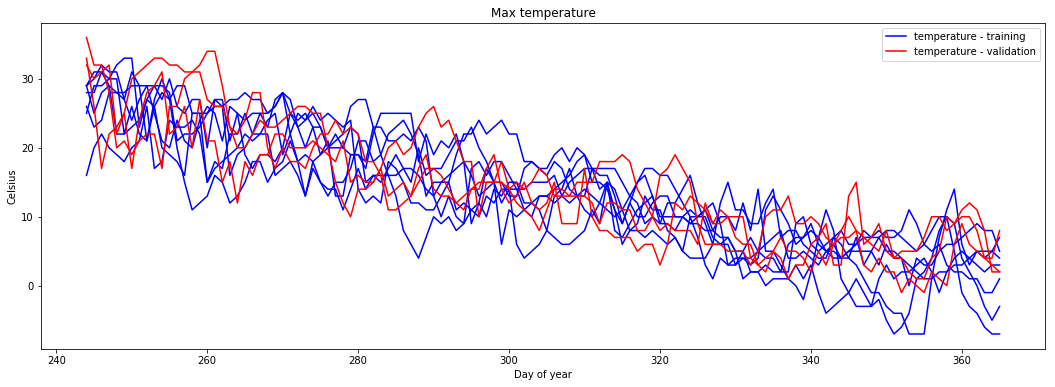

In [3]:
# Plot max temperatures to see how much they divergate

from matplotlib import pyplot as plt
%matplotlib inline

year_num = len(years)
train_year_num = len(train_years)

plt.figure(figsize=(18, 6))
plt.title('Max temperature')
plt.xlabel('Day of year')
plt.ylabel('Celsius')

for i in range(year_num):
    yeardata = data[i*days_in_year:(i+1)*days_in_year]
    if(i<train_year_num):
        plt.plot(yeardata['day'], yeardata['maxtemp'], 'b', label='') # Training data
    else:
        plt.plot(yeardata['day'], yeardata['maxtemp'], 'r', label='') # Validation data
        
plt.plot([],'b', label='temperature - training')
plt.plot([],'r', label='temperature - validation')
plt.legend(loc='upper right')
plt.show()

In [4]:
# Makes a training examples from year data with a timesteps window size

def makeXy(yearData, timesteps):
    X = []
    y = []
    
    for i in range(timesteps, yearData.shape[0]):
        X.append(list(yearData[i-timesteps:i]))
        y.append(yearData[i])
        
    X, y = np.array(X), np.array(y)
    return X, y

In [5]:
# Standard scaling, easier to scale before splitting to training and validation sets, as y values are generated from X

from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

scaler = MinMaxScaler()
scaler.fit(data[0:train_year_num*days_in_year]) # Fit scaler on training data
data = scaler.transform(data) # Scale whole dataset

# Saving scaler for prediction
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

print(data[0])

[0.6        0.         0.9        0.81081081 0.00634249 0.41818182
 0.25806452 0.9        0.71052632 0.81081081 0.82228916 0.52727273
 0.28125    0.23       0.9047619  0.89473684 0.02139037 0.42307692
 0.2        0.22       0.86363636 0.97297297 0.01147959 0.36
 0.18518519 0.92       0.6097561  0.75675676 0.56023222 0.45454545
 0.48       0.72       0.7        0.77777778 0.00512821 0.64285714
 0.2        0.63       0.82926829 0.88888889 0.07526882 0.49056604
 0.24       0.23       0.81818182 0.9        0.         0.48076923
 0.31428571 0.48       0.81395349 0.80487805 0.1905972  0.38
 0.16666667]


In [7]:
import numpy as np

timestep = 20 # Make decision from last 20 days

# Create training examples

train_X = np.empty(shape=[0,timestep,data.shape[1]])
train_y = np.empty(shape=[0,data.shape[1]])

for i in range(train_year_num):
    yeardata = data[i*days_in_year:(i+1)*days_in_year]
    X,y = makeXy(np.array(data[0:days_in_year]), timestep)
    train_X = np.append(train_X, X, axis=0)
    train_y = np.append(train_y, y, axis=0)
    
print(train_X.shape)
print(train_y.shape)

# Same for validation set

valid_X = np.empty(shape=[0,timestep,data.shape[1]])
valid_y = np.empty(shape=[0,data.shape[1]])

for i in range(train_year_num, year_num):
    yeardata = data[i*days_in_year:(i+1)*days_in_year]
    X,y = makeXy(np.array(data[0:days_in_year]), timestep)
    valid_X = np.append(valid_X, X, axis=0)
    valid_y = np.append(valid_y, y, axis=0)
    
print(valid_X.shape)
print(valid_y.shape)

(714, 20, 55)
(714, 55)
(306, 20, 55)
(306, 55)


In [8]:
# Reshape X values
train_X = train_X.reshape(train_X.shape[0], -1)
valid_X = valid_X.reshape(valid_X.shape[0], -1)

print(train_X.shape)
print(train_y.shape)

print(valid_X.shape)
print(valid_y.shape)

(714, 1100)
(714, 55)
(306, 1100)
(306, 55)


In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from tensorflow import set_random_seed

# Set random seed to always predict the same values
np.random.seed(1)
set_random_seed(2) # Tensoflow

D:\ProgramFiles\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
# Saving loss and acc values

class TrainingHistory(Callback):

    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()

In [11]:
# Create model

# Tried activation functions: relu, tanh, but sigmoid showed as the best solution
# Also tried more/less layers and more/less neurons per layer

model = Sequential()
model.add(Dense(200, activation='sigmoid', input_shape=(train_X.shape[1],)))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(train_y.shape[1], activation='sigmoid'))
model.compile(loss='mean_squared_error',
              optimizer= Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])

model.save('model.h5') # Saving model for prediction

In [13]:
# Setting up early stopping and weight saving on actually best solutions

from keras.callbacks import EarlyStopping
patience=30
early_stopping=EarlyStopping(patience=patience, verbose=1)

from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

In [14]:
# Training model
# Batch size 4 seems to be the best solution

model.fit(train_X, train_y,
          batch_size=4,
          epochs=2500,
          verbose=2, 
          validation_data=(valid_X,valid_y), 
          callbacks=[checkpointer, early_stopping, history], 
          shuffle= True)

Train on 714 samples, validate on 306 samples
Epoch 1/2500
 - 1s - loss: 0.0304 - acc: 0.0938 - val_loss: 0.0224 - val_acc: 0.2255

Epoch 00001: val_loss improved from inf to 0.02237, saving model to weights.hdf5
Epoch 2/2500
 - 0s - loss: 0.0205 - acc: 0.1653 - val_loss: 0.0174 - val_acc: 0.1373

Epoch 00002: val_loss improved from 0.02237 to 0.01735, saving model to weights.hdf5
Epoch 3/2500
 - 0s - loss: 0.0151 - acc: 0.2115 - val_loss: 0.0139 - val_acc: 0.2255

Epoch 00003: val_loss improved from 0.01735 to 0.01392, saving model to weights.hdf5
Epoch 4/2500
 - 0s - loss: 0.0115 - acc: 0.2353 - val_loss: 0.0099 - val_acc: 0.2647

Epoch 00004: val_loss improved from 0.01392 to 0.00990, saving model to weights.hdf5
Epoch 5/2500
 - 0s - loss: 0.0091 - acc: 0.2577 - val_loss: 0.0077 - val_acc: 0.2353

Epoch 00005: val_loss improved from 0.00990 to 0.00774, saving model to weights.hdf5
Epoch 6/2500
 - 0s - loss: 0.0073 - acc: 0.2605 - val_loss: 0.0064 - val_acc: 0.3333

Epoch 00006: val_


Epoch 00050: val_loss did not improve from 0.00016
Epoch 51/2500
 - 0s - loss: 2.1007e-04 - acc: 0.8235 - val_loss: 4.0614e-04 - val_acc: 0.7843

Epoch 00051: val_loss did not improve from 0.00016
Epoch 52/2500
 - 0s - loss: 2.3750e-04 - acc: 0.8221 - val_loss: 1.2674e-04 - val_acc: 0.8431

Epoch 00052: val_loss improved from 0.00016 to 0.00013, saving model to weights.hdf5
Epoch 53/2500
 - 0s - loss: 1.5056e-04 - acc: 0.8305 - val_loss: 2.2896e-04 - val_acc: 0.7941

Epoch 00053: val_loss did not improve from 0.00013
Epoch 54/2500
 - 0s - loss: 1.8481e-04 - acc: 0.8193 - val_loss: 1.0775e-04 - val_acc: 0.8333

Epoch 00054: val_loss improved from 0.00013 to 0.00011, saving model to weights.hdf5
Epoch 55/2500
 - 0s - loss: 1.2975e-04 - acc: 0.8361 - val_loss: 9.8048e-05 - val_acc: 0.8235

Epoch 00055: val_loss improved from 0.00011 to 0.00010, saving model to weights.hdf5
Epoch 56/2500
 - 0s - loss: 1.4426e-04 - acc: 0.8361 - val_loss: 1.5387e-04 - val_acc: 0.8627

Epoch 00056: val_loss


Epoch 00104: val_loss did not improve from 0.00004
Epoch 105/2500
 - 0s - loss: 2.9433e-04 - acc: 0.8263 - val_loss: 2.2834e-04 - val_acc: 0.8333

Epoch 00105: val_loss did not improve from 0.00004
Epoch 106/2500
 - 0s - loss: 1.3768e-04 - acc: 0.8459 - val_loss: 6.3653e-05 - val_acc: 0.8824

Epoch 00106: val_loss did not improve from 0.00004
Epoch 107/2500
 - 0s - loss: 4.3814e-05 - acc: 0.8571 - val_loss: 4.5063e-05 - val_acc: 0.8431

Epoch 00107: val_loss did not improve from 0.00004
Epoch 108/2500
 - 0s - loss: 3.4013e-05 - acc: 0.8585 - val_loss: 3.4693e-05 - val_acc: 0.8725

Epoch 00108: val_loss improved from 0.00004 to 0.00003, saving model to weights.hdf5
Epoch 109/2500
 - 0s - loss: 2.8202e-05 - acc: 0.8585 - val_loss: 3.6844e-05 - val_acc: 0.8627

Epoch 00109: val_loss did not improve from 0.00003
Epoch 110/2500
 - 0s - loss: 5.3467e-05 - acc: 0.8459 - val_loss: 7.3152e-05 - val_acc: 0.8431

Epoch 00110: val_loss did not improve from 0.00003
Epoch 111/2500
 - 0s - loss: 1.6


Epoch 00159: val_loss did not improve from 0.00002
Epoch 160/2500
 - 0s - loss: 1.3680e-04 - acc: 0.8361 - val_loss: 8.1898e-05 - val_acc: 0.8529

Epoch 00160: val_loss did not improve from 0.00002
Epoch 161/2500
 - 0s - loss: 4.9978e-05 - acc: 0.8627 - val_loss: 2.8445e-05 - val_acc: 0.8627

Epoch 00161: val_loss did not improve from 0.00002
Epoch 162/2500
 - 0s - loss: 2.4477e-05 - acc: 0.8711 - val_loss: 2.0990e-05 - val_acc: 0.8922

Epoch 00162: val_loss did not improve from 0.00002
Epoch 163/2500
 - 1s - loss: 1.9626e-05 - acc: 0.8754 - val_loss: 2.3219e-05 - val_acc: 0.8824

Epoch 00163: val_loss did not improve from 0.00002
Epoch 164/2500
 - 1s - loss: 7.0407e-05 - acc: 0.8571 - val_loss: 1.6040e-04 - val_acc: 0.8824

Epoch 00164: val_loss did not improve from 0.00002
Epoch 165/2500
 - 0s - loss: 1.9695e-04 - acc: 0.8361 - val_loss: 2.1304e-04 - val_acc: 0.8725

Epoch 00165: val_loss did not improve from 0.00002
Epoch 166/2500
 - 0s - loss: 1.3558e-04 - acc: 0.8529 - val_loss: 

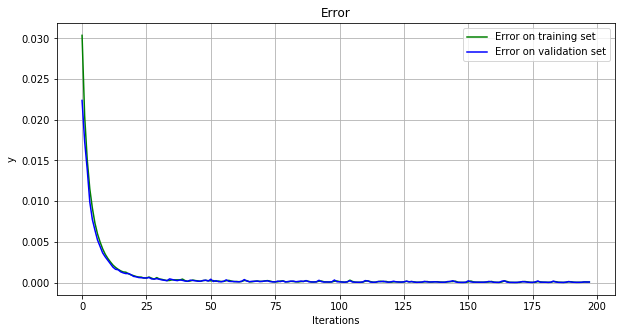

In [15]:
plt.figure(figsize=(10, 5))
plt.title('Error')
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Error on training set') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Error on validation set')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('y')
plt.grid(True)
plt.show()